<a href="https://colab.research.google.com/github/raza4729/Machine-Learning/blob/master/PhysicsInformedML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Predicting Vehicle Acceleration using Throttle & Resistence at current snapshot without considering history



In [3]:
def simulate_data(n=1000, mass=1000, g=9.81):
    throttle = np.random.uniform(0, 1, size=n)  # normalized throttle
    grade = np.random.uniform(-5, 5, size=n)    # slope in degrees

    resistance = mass * g * np.sin(np.radians(grade)) + 0.03 * mass * g  # adding rolling resistence coefficient to include tyre resistence
    acceleration = (throttle * 1000 - resistance) / mass

    X = np.stack([throttle, grade], axis=1)
    y = acceleration

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [4]:
X, y= simulate_data()
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

## A simple Feed Forward Neural Network model for modeling throttle and grade features



We are using two features with a linear layer of dimenssion 64 and ReLU as activation function.

In [5]:
class BaselineNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)


### We are using a slightly modified loss function for physics informed model as compared to baseline model which uses mean-squared error.


In [7]:
def physics_based_loss(pred, X, mass=1000, g=9.81):
    throttle, grade = X[:, 0], X[:, 1]
    resistance = mass * g * torch.sin(torch.deg2rad(grade)) + 0.3 * mass * g
    expected = (throttle * 1000 - resistance) / mass
    return torch.mean((pred.squeeze() - expected) ** 2)

(1000,) [1132.41466439  368.15772382 1044.13048552 -510.64177377  870.92705869]


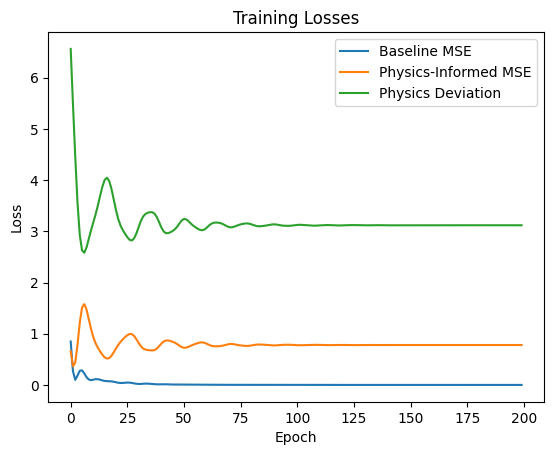

In [11]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Data
X, y = simulate_data()
train_X, train_y = X[:800], y[:800]
val_X, val_y = X[800:], y[800:]

# Models
baseline = BaselineNN()
physics_model = BaselineNN()

# Optimizers
opt_base = optim.Adam(baseline.parameters(), lr=0.01)
opt_phys = optim.Adam(physics_model.parameters(), lr=0.01)

# Losses
mse = nn.MSELoss()

base_losses, phys_losses, phys_reg = [], [], []

for epoch in range(200):  # training for 200 epochs
    # === Baseline ===
    opt_base.zero_grad()
    pred_base = baseline(train_X).squeeze()
    loss_base = mse(pred_base, train_y)
    loss_base.backward()
    opt_base.step()
    base_losses.append(loss_base.item())

    # === Physics-informed ===
    '''the difference '''
    opt_phys.zero_grad()
    pred_phys = physics_model(train_X).squeeze()
    loss_pred = mse(pred_phys, train_y)
    loss_phys = physics_based_loss(pred_phys, train_X)
    loss_total = loss_pred + 0.5 * loss_phys  # lambda = 0.5
    loss_total.backward()
    opt_phys.step()
    phys_losses.append(loss_pred.item())
    phys_reg.append(loss_phys.item())

# Plot losses
plt.plot(base_losses, label="Baseline MSE")
plt.plot(phys_losses, label="Physics-Informed MSE")
plt.plot(phys_reg, label="Physics Deviation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.show()


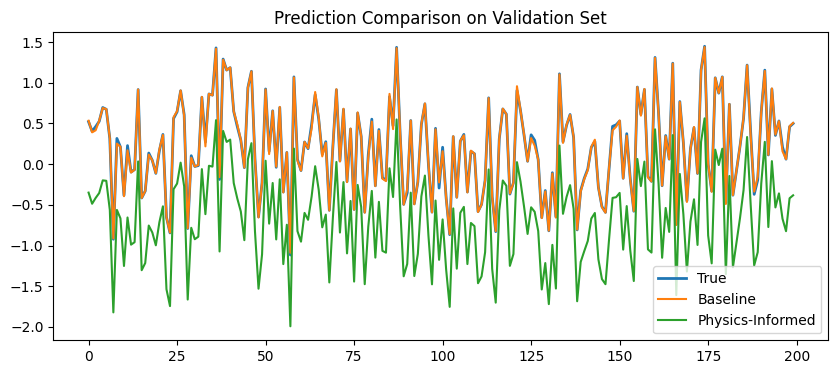

In [12]:
import matplotlib.pyplot as plt

with torch.no_grad():
    pred_base = baseline(val_X).squeeze()
    pred_phys = physics_model(val_X).squeeze()

plt.figure(figsize=(10,4))
plt.plot(val_y.numpy(), label="True", linewidth=2)
plt.plot(pred_base.numpy(), label="Baseline")
plt.plot(pred_phys.numpy(), label="Physics-Informed")
plt.legend()
plt.title("Prediction Comparison on Validation Set")
plt.show()
